In [1]:
import os
import numpy as np
import scipy.ndimage
import skimage.feature
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bgr_imgs = [cv2.imread(f'imgs/{name}', cv2.IMREAD_COLOR) for name in sorted(os.listdir('imgs'))]
gray_imgs = [cv2.imread(f'imgs/{name}', cv2.IMREAD_GRAYSCALE) for name in sorted(os.listdir('imgs'))]
imgs_bboxes = np.load('imgs_bboxes.npy').item()
imgs_inversions = np.load('imgs_inversions.npy').item()

In [3]:
imgs_out = []
for i, (img, bboxes, invs) in enumerate(zip(bgr_imgs, imgs_bboxes.values(), imgs_inversions.values())):
    img_out = np.zeros((img.shape[0], img.shape[1]))
    for b, (bbox, inv) in enumerate(zip(bboxes, invs)):
        text = cv2.cvtColor(img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]], cv2.COLOR_BGR2GRAY)
        if inv:
            text = 255 - text
        img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = text
    imgs_out.append(img_out.astype(np.uint8))
    
thr_imgs = [cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5) for img in imgs_out]
nlm_imgs = [cv2.fastNlMeansDenoising(img,None,40,7,15) for img in thr_imgs]
imgs_out = []
for i, (img, bboxes) in enumerate(zip(nlm_imgs, imgs_bboxes.values())):
    img_out = 255*np.ones((img.shape[0], img.shape[1]))
    for b, bbox in enumerate(bboxes):
        text = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = text
    imgs_out.append(img_out.astype(np.uint8))

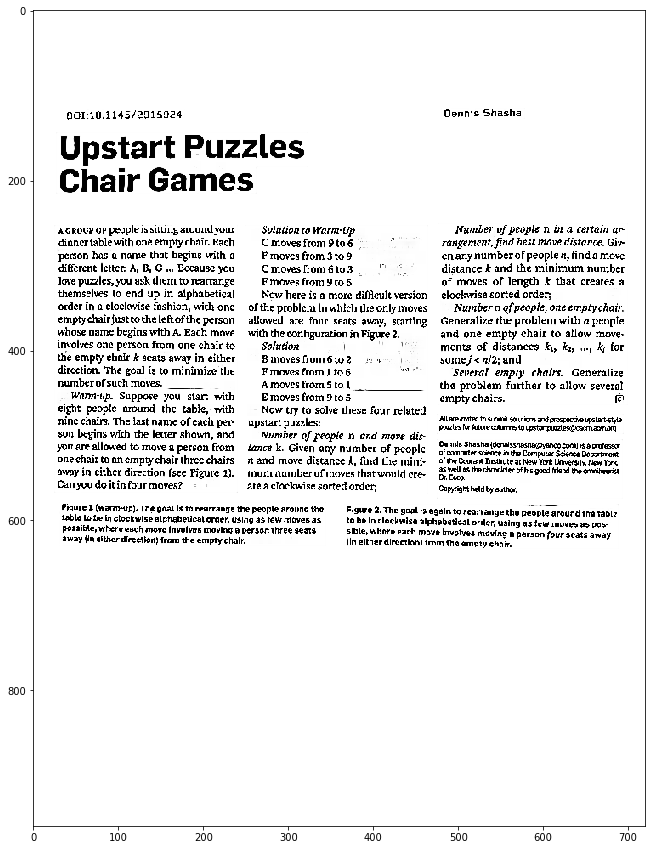

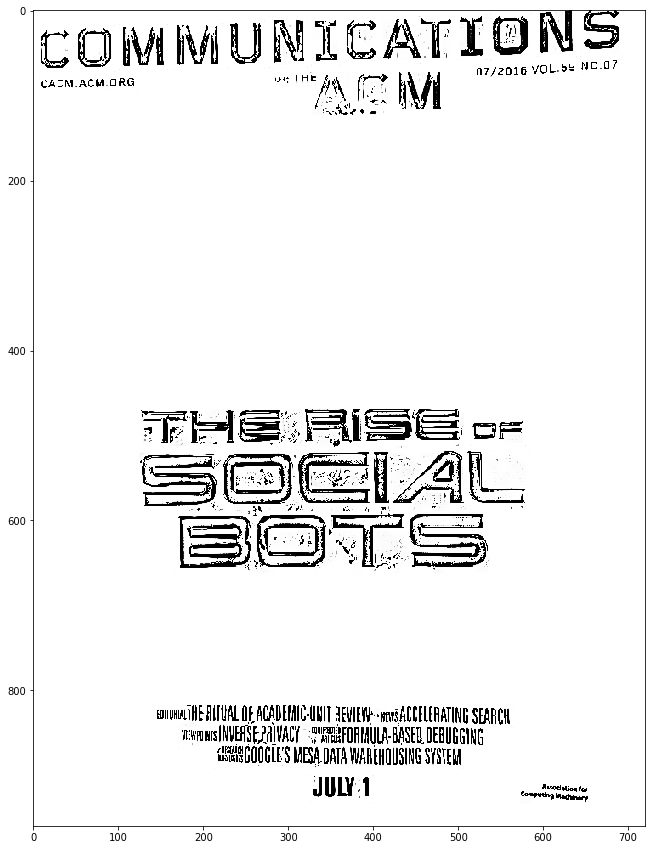

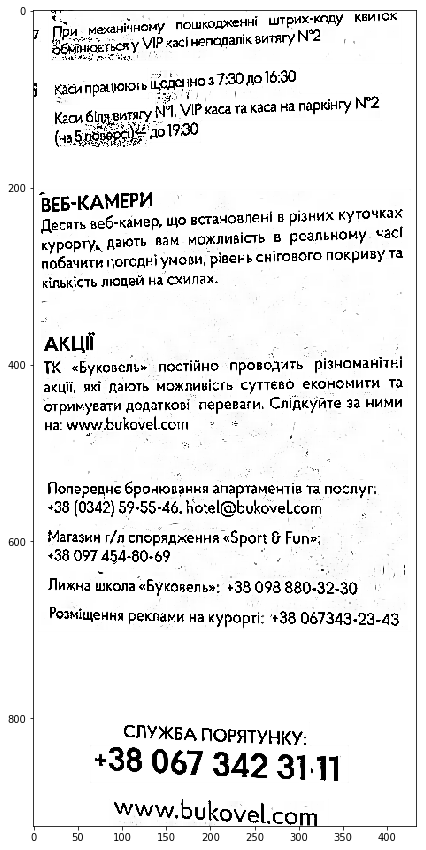

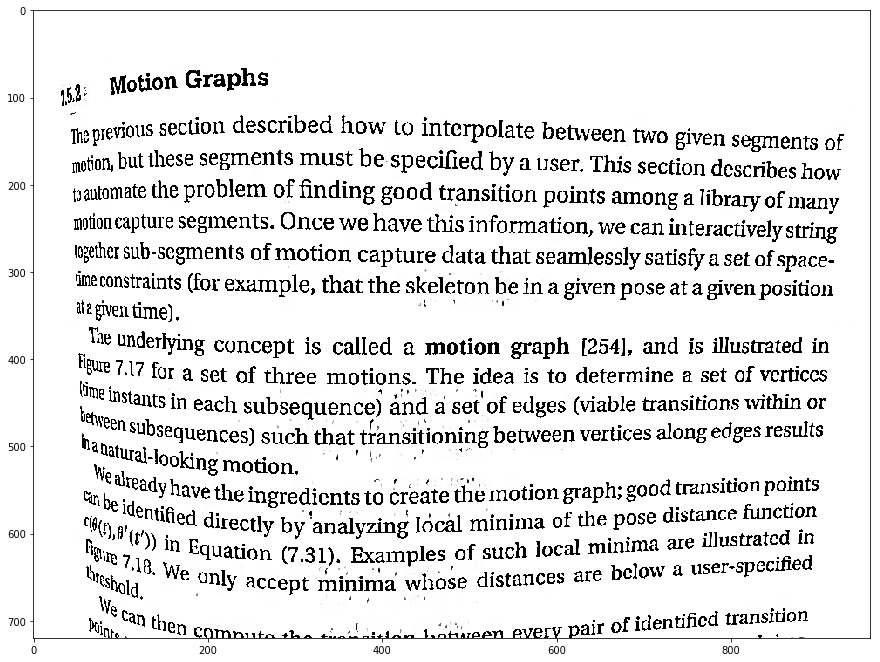

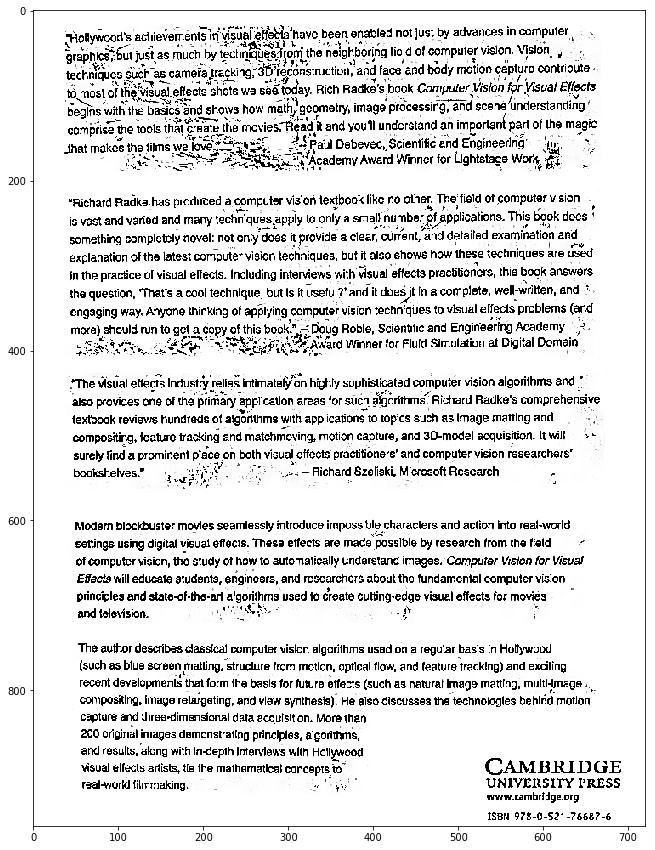

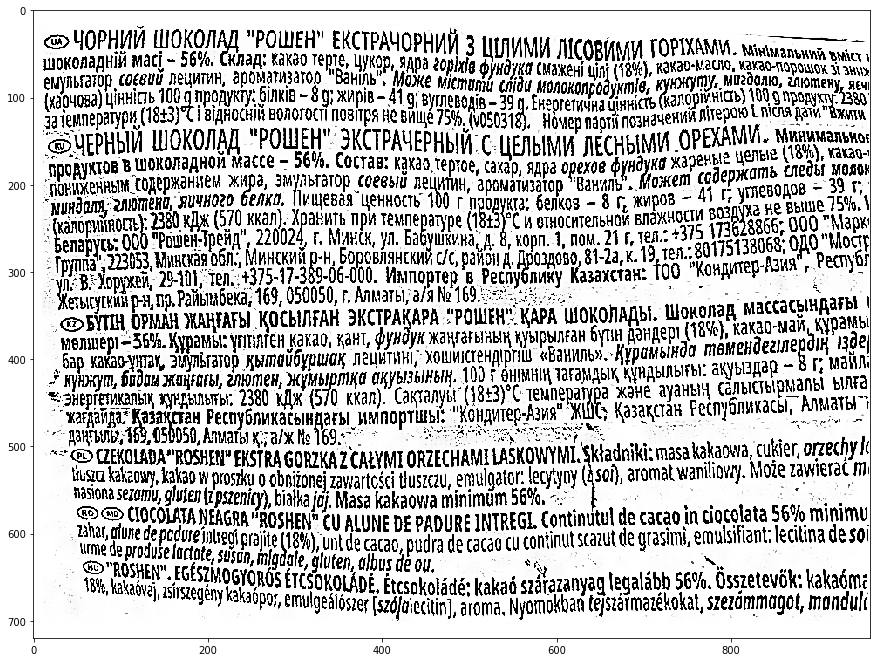

In [4]:
for img in imgs_out:
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
    plt.show()